In [1]:

import datetime
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import numpy as np
import requests
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("df_combined.csv", index_col=False)

In [3]:
df = df.iloc[:, 1:]
df['date']=pd.to_datetime(df.date)
del df['v39050']
del df['v39079']
df = df.rename(columns={ 'v39078': 'rate'})

In [4]:
# Create lagged features for the target and exogenous variables
def create_lagged_features(df, target_col, exog_cols, lags=[1, 3, 6]):
    df_lagged = df.copy()
    # Lagged features for the target
    for lag in lags:
        df_lagged[f'{target_col}_lag{lag}'] = df_lagged[target_col].shift(lag)
    # Lagged features for exogenous variables
    for col in exog_cols:
        for lag in lags:
            df_lagged[f'{col}_lag{lag}'] = df_lagged[col].shift(lag)
    return df_lagged

In [5]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [6]:
# Define exogenous variables
exog_vars = ['bond_yield_1_yr', 'bond_yield_5_yr', 'bond_yield_10_yr', 'us_funds_rate', 'cpi_yoy', 'production_yoy']

# Create lagged features
df = create_lagged_features(df, 'rate', exog_vars, lags=[1, 3, 6])

In [7]:
features = ['year', 'month'] + exog_vars
for lag in [1, 3, 6]:
    features += [f'rate_lag{lag}']
    for col in exog_vars:
        features += [f'{col}_lag{lag}']

In [8]:
df = df.dropna()

In [9]:
train_size = int(len(df) * 0.85)
df_train = df[:train_size]
df_test = df[train_size:]

X_train = df_train[features]
y_train = df_train['rate']
X_test = df_test[features]
y_test = df_test['rate']


print(f"Training period: {df_train['date'].iloc[0].date()} to {df_train['date'].iloc[-1].date()}")
print(f"Testing period: {df_test['date'].iloc[0].date()} to {df_test['date'].iloc[-1].date()}")

Training period: 2017-12-01 to 2024-02-01
Testing period: 2024-03-01 to 2025-04-01


In [10]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
test_forecast = xgb_model.predict(X_test)

In [12]:
rmse = np.sqrt(mean_squared_error(y_test, test_forecast))
print(f'RMSE: {rmse}')

RMSE: 0.956368686686271


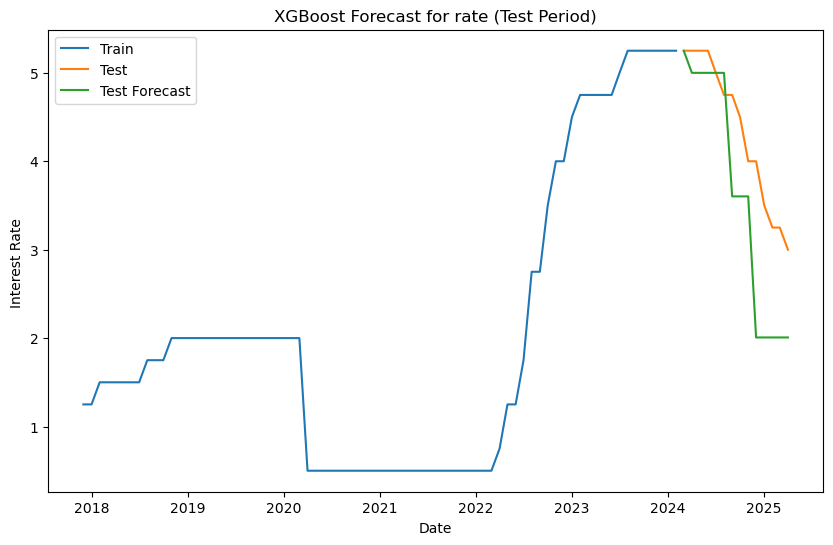

In [13]:
# Plot train, test, and forecast
plt.figure(figsize=(10, 6))
plt.plot(df_train['date'], df_train['rate'], label='Train')
plt.plot(df_test['date'], df_test['rate'], label='Test')
plt.plot(df_test['date'], test_forecast, label='Test Forecast')
plt.title('XGBoost Forecast for rate (Test Period)')
plt.xlabel('Date')
plt.ylabel('Interest Rate ')
plt.legend()
plt.show()

In [14]:
future_dates = pd.date_range(start='2025-05-01', end='2025-10-01', freq='MS')
future_df = pd.DataFrame({'date': future_dates})
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month


In [15]:
last_row = df.iloc[-1].copy()

for col in exog_vars:
    future_df[col] = last_row[col]

# Add columns for lagged features in future_df
for lag in [1, 3, 6]:
    future_df[f'rate_lag{lag}'] = np.nan
    for col in exog_vars:
        future_df[f'{col}_lag{lag}'] = last_row[f'{col}_lag{lag}']  # Use last known lagged values

In [16]:
future_forecasts = []
last_known_values = df.copy()

In [17]:
for i in range(len(future_dates)):
    # Prepare the current row for prediction
    current_row = future_df.iloc[i:i+1][features].copy()
    
    # Update lagged features for rate
    for lag in [1, 3, 6]:
        if i >= lag:
            # Use previously forecasted values
            future_df.iloc[i, future_df.columns.get_loc(f'rate_lag{lag}')] = future_forecasts[i - lag]
        else:
            # Use historical values for initial lags
            future_df.iloc[i, future_df.columns.get_loc(f'rate_lag{lag}')] = last_known_values['rate'].iloc[-lag]
    
    # Update the current row with the latest lagged values
    current_row = future_df.iloc[i:i+1][features].copy()
    pred = xgb_model.predict(current_row)[0]
    future_forecasts.append(pred)

In [18]:
future_df['yhat']=future_forecasts

In [19]:
df_output_future=future_df[['date','year','month','bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy','yhat']]
df_output_test=df_test[['date','year','month','bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy' ]]
df_output_test['yhat']=test_forecast
df_output_test['type']='test'
df_output_future['type']='future'
df_output_test['model']='XGBoost'
df_output_future['model']='XGBoost'



In [20]:
df_orig=df[['date','year','month','bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy','rate']].copy()
df_orig=df_orig.merge(df_output_test[['date','yhat','model','type']],  how='left', left_on='date', right_on='date')
union_df = pd.concat([df_orig,df_output_future ])

In [21]:

union_df['model']='XGBoost'
union_df['type']=union_df['type'].fillna('train')

In [22]:
union_df.to_csv("model_forecast_xgboost.csv",index=False)